In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# loading the data

In [2]:
df_train = pd.read_csv('train_users.csv')
df_test = pd.read_csv('test_users.csv')

In [3]:
df_train.shape

(2000, 33)

In [4]:
df_test.shape

(2000, 32)

In [5]:
df_train.columns

Index(['user_id', 'age', 'income', 'clicks', 'purchase_amount',
       'session_duration', 'content_variety', 'engagement_score',
       'num_transactions', 'avg_monthly_spend', 'avg_cart_value',
       'browsing_depth', 'revisit_rate', 'scroll_activity', 'time_on_site',
       'interaction_count', 'preferred_price_range', 'discount_usage_rate',
       'wishlist_size', 'product_views', 'repeat_purchase_gap (days)',
       'churn_risk_score', 'loyalty_index', 'screen_brightness',
       'battery_percentage', 'cart_abandonment_count', 'browser_version',
       'background_app_count', 'session_inactivity_duration', 'network_jitter',
       'region_code', 'subscriber', 'label'],
      dtype='object')

In [6]:
df_test.columns

Index(['user_id', 'age', 'income', 'clicks', 'purchase_amount',
       'session_duration', 'content_variety', 'engagement_score',
       'num_transactions', 'avg_monthly_spend', 'avg_cart_value',
       'browsing_depth', 'revisit_rate', 'scroll_activity', 'time_on_site',
       'interaction_count', 'preferred_price_range', 'discount_usage_rate',
       'wishlist_size', 'product_views', 'repeat_purchase_gap (days)',
       'churn_risk_score', 'loyalty_index', 'screen_brightness',
       'battery_percentage', 'cart_abandonment_count', 'browser_version',
       'background_app_count', 'session_inactivity_duration', 'network_jitter',
       'region_code', 'subscriber'],
      dtype='object')

In [7]:
print(df_train.shape)
print(df_train.dtypes)
print("\nUnique labels:", df_train["label"].unique())
print("\nLabel counts:\n", df_train["label"].value_counts())
print("\nLabel proportions:\n", df_train["label"].value_counts(normalize=True))


(2000, 33)
user_id                         object
age                            float64
income                           int64
clicks                           int64
purchase_amount                float64
session_duration               float64
content_variety                float64
engagement_score               float64
num_transactions                 int64
avg_monthly_spend              float64
avg_cart_value                 float64
browsing_depth                   int64
revisit_rate                   float64
scroll_activity                  int64
time_on_site                   float64
interaction_count                int64
preferred_price_range          float64
discount_usage_rate            float64
wishlist_size                    int64
product_views                    int64
repeat_purchase_gap (days)     float64
churn_risk_score               float64
loyalty_index                  float64
screen_brightness              float64
battery_percentage             float64
cart_abandonme

# box plot for features

In [8]:
df_train["subscriber"] = df_train["subscriber"].astype(int)


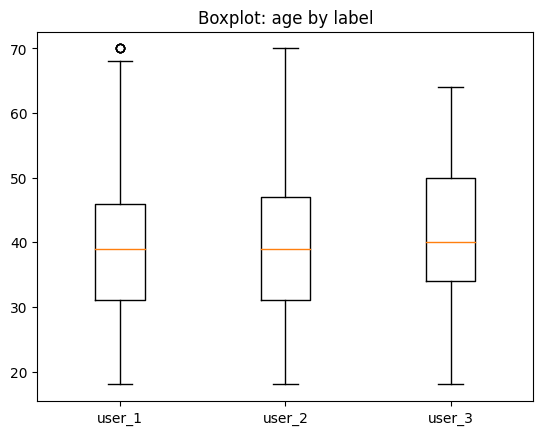

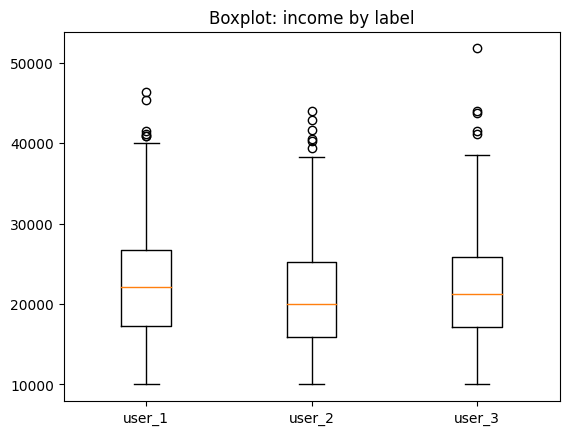

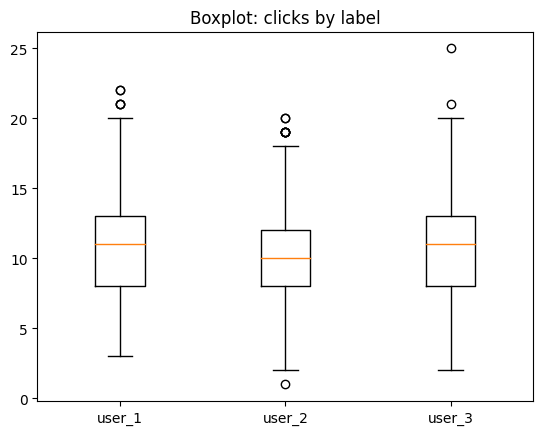

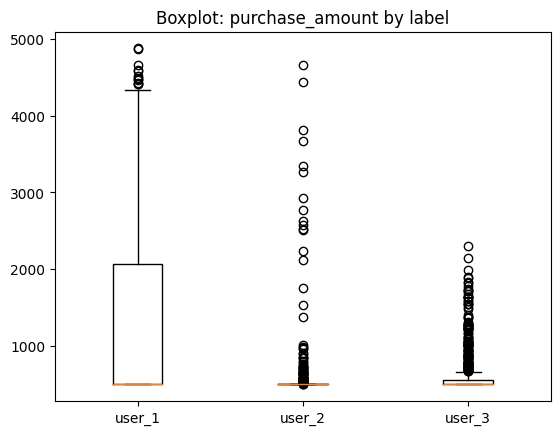

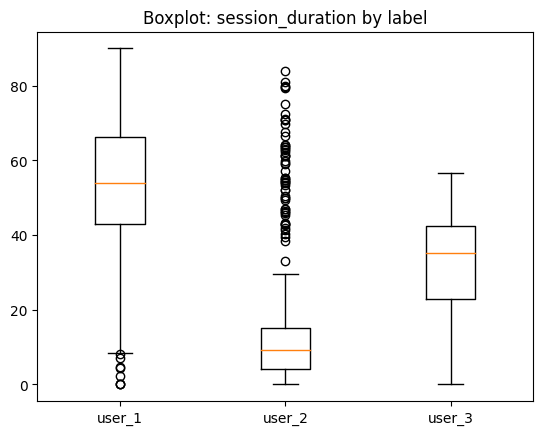

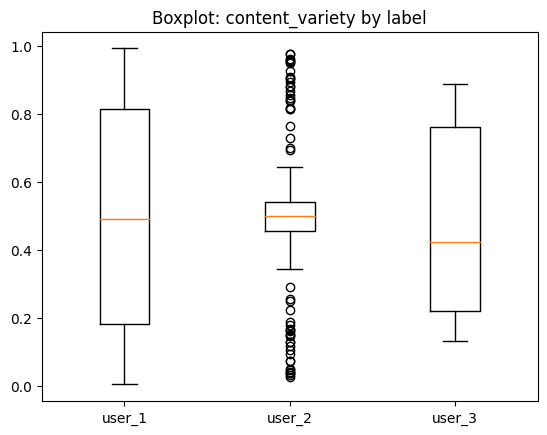

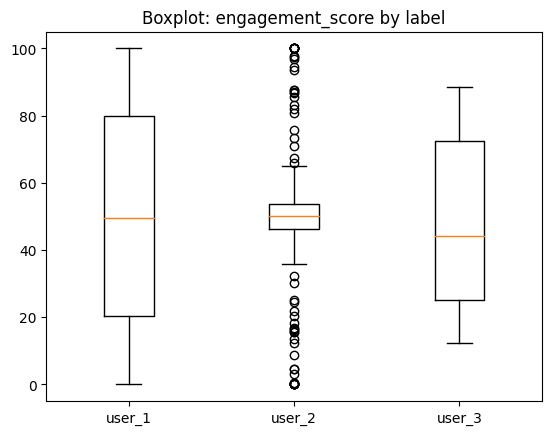

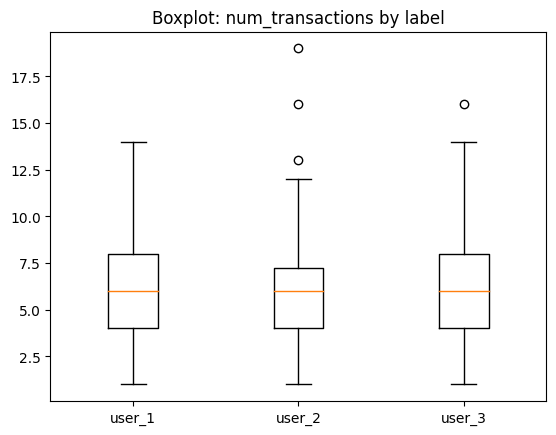

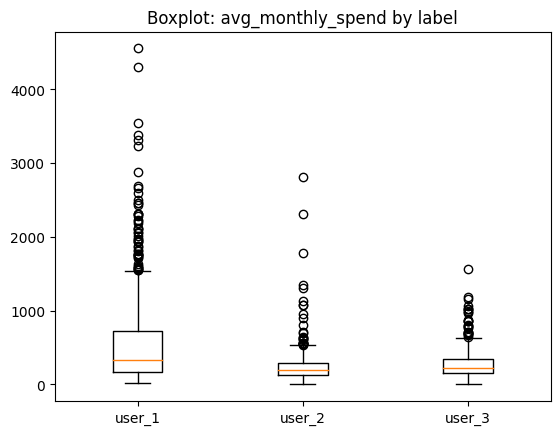

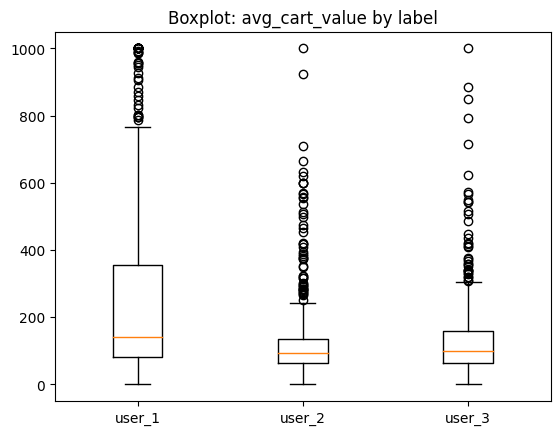

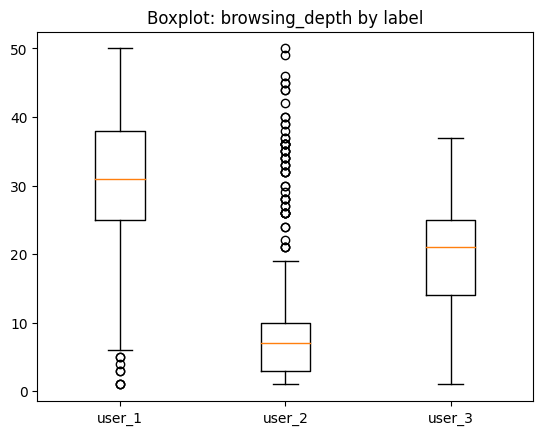

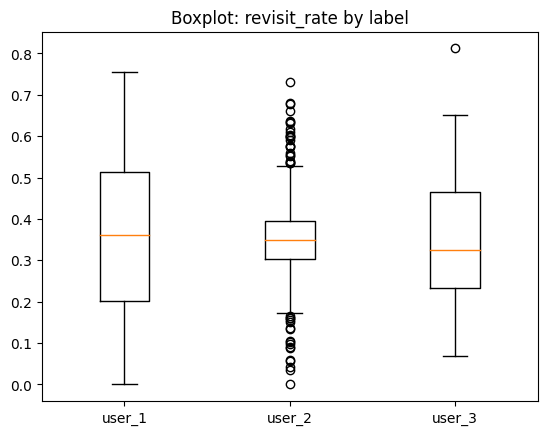

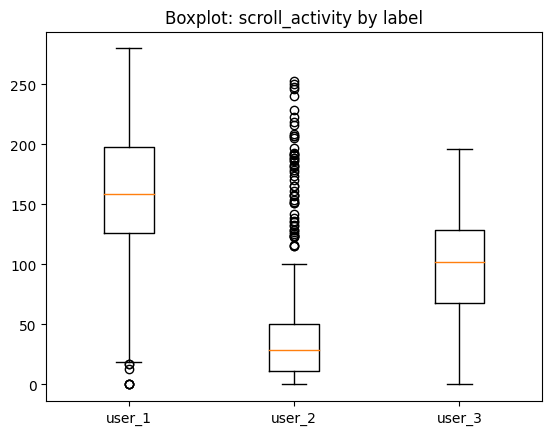

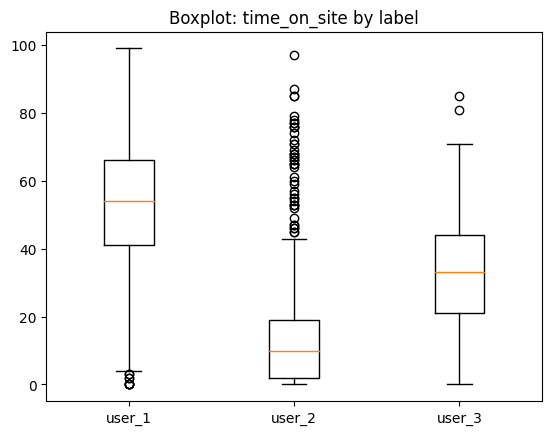

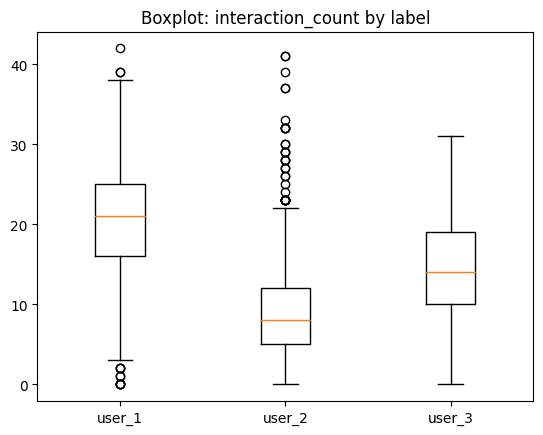

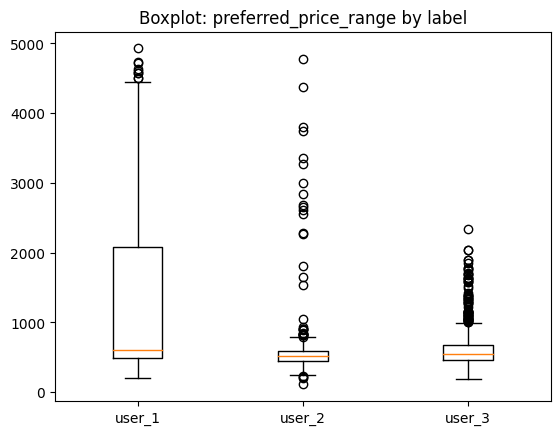

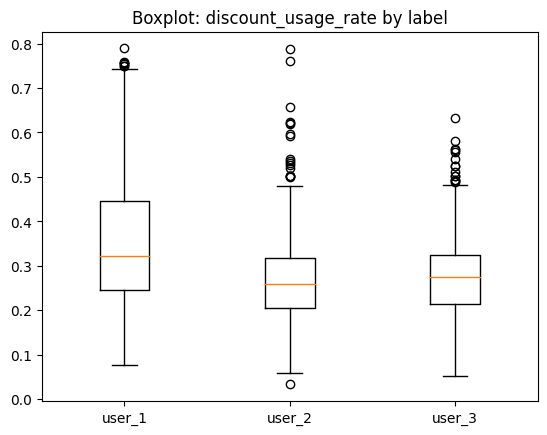

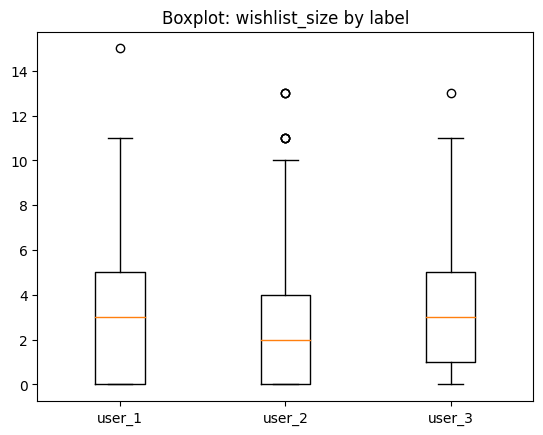

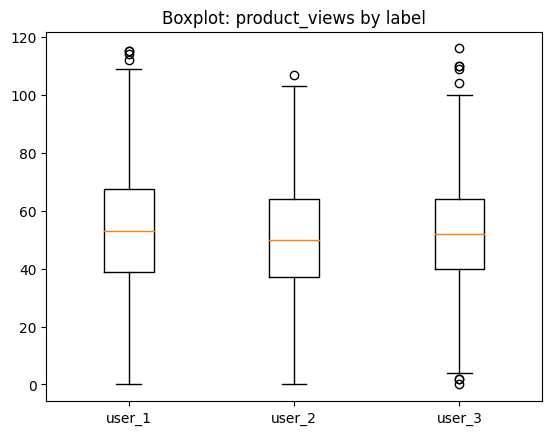

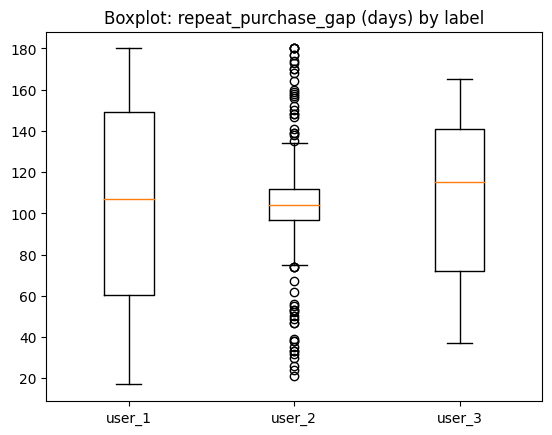

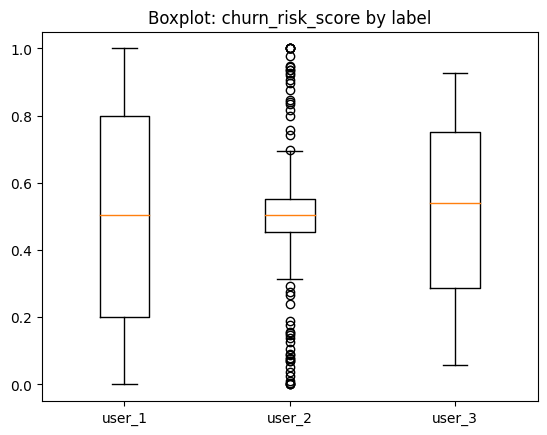

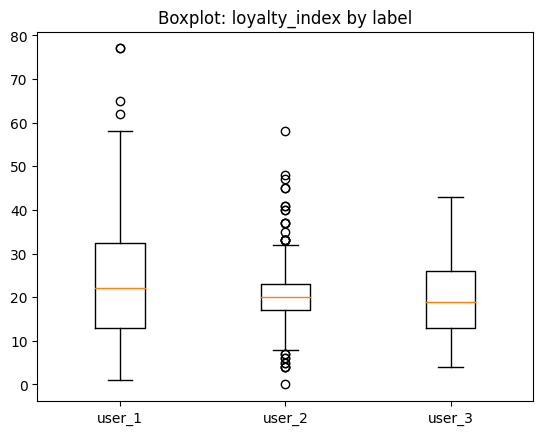

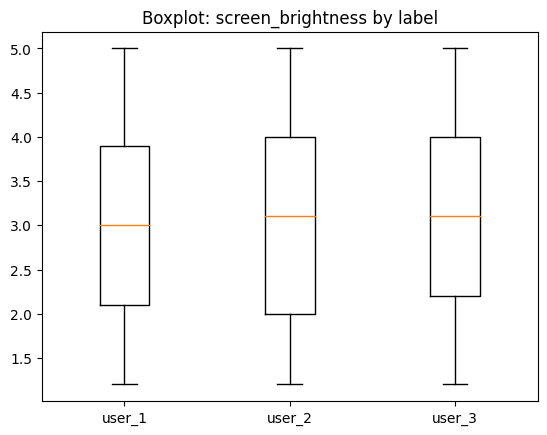

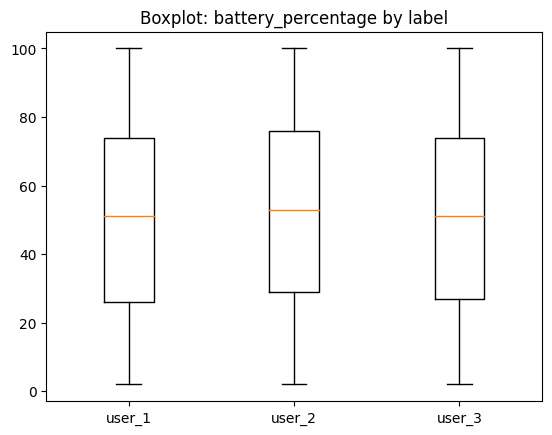

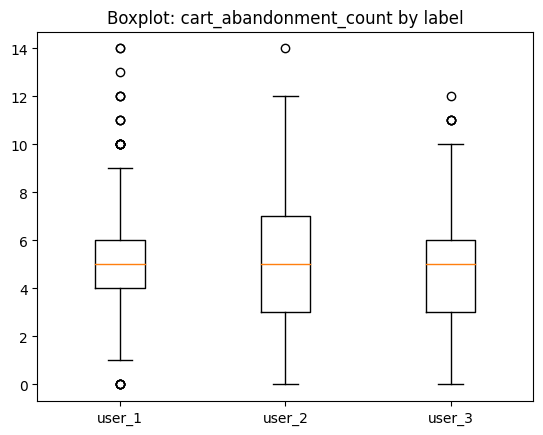

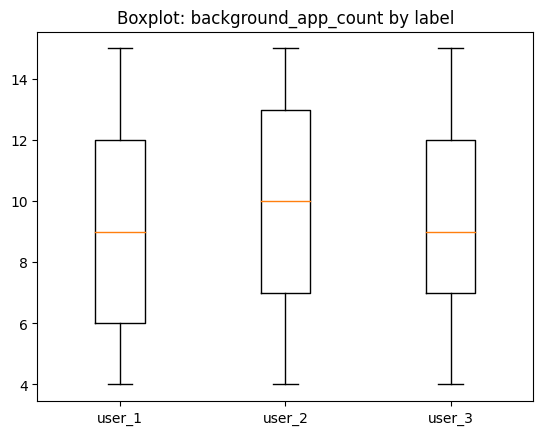

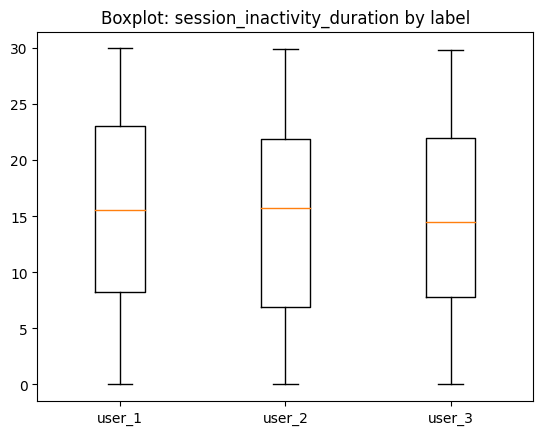

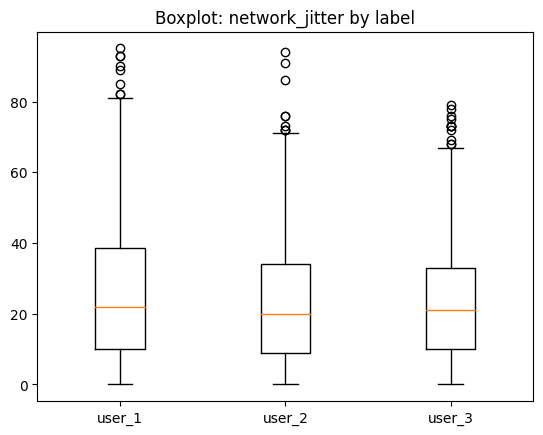

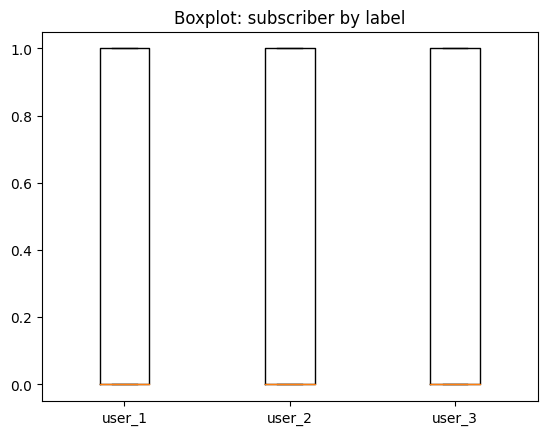

In [9]:
feat_cols = [c for c in df_train.columns if c not in ["user_id", "label", "browser_version", "region_code"]]

for c in feat_cols:
    plt.figure()
    data = [df_train[df_train["label"]==lab][c].dropna() for lab in sorted(df_train["label"].unique())]
    plt.boxplot(data, labels=sorted(df_train["label"].unique()))
    plt.title(f"Boxplot: {c} by label")
    plt.show()


In [10]:
df_train["browser_version"].unique().shape

(1973,)

In [11]:
df_train["user_id"].unique().shape

(1804,)

# applying different models with cross validation

In [12]:
feat_cols = [c for c in df_train.columns if c not in ["user_id", "label", "browser_version", "region_code"]]
target = "label"

X = df_train[feat_cols]
y = df_train["label"].astype(str)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

prep_tree = ColumnTransformer(
    [("num", SimpleImputer(strategy="median"), feat_cols)],
    remainder="drop"
)

prep_scaled = ColumnTransformer(
    [("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), feat_cols)],
    remainder="drop"
)

models = {
    "DecisionTree": Pipeline([
        ("prep", prep_tree),
        ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("prep", prep_tree),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            class_weight="balanced_subsample",
            n_jobs=-1
        ))
    ]),
    "HistGradientBoosting": Pipeline([
        ("prep", prep_tree),
        ("clf", HistGradientBoostingClassifier(
            max_depth=6, learning_rate=0.05, max_iter=800, random_state=42
        ))
    ]),
    "LogisticRegression": Pipeline([
        ("prep", prep_scaled),
        ("clf", LogisticRegression(
            max_iter=5000,
            class_weight="balanced",
            n_jobs=-1
        ))
    ]),
    "SVM_RBF": Pipeline([
        ("prep", prep_scaled),
        ("clf", SVC(
            kernel="rbf",
            C=10,
            gamma="scale",
            class_weight="balanced"
        ))
    ]),
    "MLP": Pipeline([
        ("prep", prep_scaled),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64, 64),
            alpha=1e-4,
            max_iter=1000,
            random_state=42
        ))
    ]),
}

scoring = {
    "acc": "accuracy",
    "macro_f1": "f1_macro"
}

rows = []
for name, model in models.items():
    out = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    acc_mean, acc_std = out["test_acc"].mean(), out["test_acc"].std()
    f1_mean, f1_std = out["test_macro_f1"].mean(), out["test_macro_f1"].std()

    rows.append([name, acc_mean, acc_std, f1_mean, f1_std])

results = pd.DataFrame(rows, columns=["model", "acc_mean", "acc_std", "macroF1_mean", "macroF1_std"])
results = results.sort_values("acc_mean", ascending=False)

print(results.to_string(index=False))


/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/varchitalalwa

               model  acc_mean  acc_std  macroF1_mean  macroF1_std
HistGradientBoosting    0.8235 0.034627      0.821168     0.035019
        RandomForest    0.8225 0.029707      0.818340     0.029490
             SVM_RBF    0.7610 0.014714      0.754818     0.014637
  LogisticRegression    0.7425 0.028810      0.732835     0.028529
        DecisionTree    0.7325 0.025884      0.726899     0.025379
                 MLP    0.7255 0.027991      0.719082     0.027383


# checking with PCA 

In [13]:


feat_cols = [c for c in df_train.columns if c not in ["user_id", "label", "browser_version", "region_code"]]
target = "label"

X = df_train[feat_cols]
y = df_train[target].astype(str)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# shared preprocessing: impute -> scale -> PCA(5)
prep_pca5 = ColumnTransformer(
    [("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5, random_state=42)),
    ]), feat_cols)],
    remainder="drop"
)

models_pca = {
    "DecisionTree_PCA5": Pipeline([
        ("prep", prep_pca5),
        ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))
    ]),
    "RandomForest_PCA5": Pipeline([
        ("prep", prep_pca5),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            class_weight="balanced_subsample",
            n_jobs=-1
        ))
    ]),
    "HistGradientBoosting_PCA5": Pipeline([
        ("prep", prep_pca5),
        ("clf", HistGradientBoostingClassifier(
            max_depth=6, learning_rate=0.05, max_iter=800, random_state=42
        ))
    ]),
    "LogisticRegression_PCA5": Pipeline([
        ("prep", prep_pca5),
        ("clf", LogisticRegression(
            max_iter=5000,
            class_weight="balanced",
            n_jobs=-1
        ))
    ]),
    "SVM_RBF_PCA5": Pipeline([
        ("prep", prep_pca5),
        ("clf", SVC(
            kernel="rbf",
            C=10,
            gamma="scale",
            class_weight="balanced"
        ))
    ]),
    "MLP_PCA5": Pipeline([
        ("prep", prep_pca5),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64, 64),
            alpha=1e-4,
            max_iter=1000,
            random_state=42
        ))
    ]),
}

scoring = {"acc": "accuracy", "macro_f1": "f1_macro"}

rows = []
for name, model in models_pca.items():
    out = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    rows.append([
        name,
        out["test_acc"].mean(), out["test_acc"].std(),
        out["test_macro_f1"].mean(), out["test_macro_f1"].std()
    ])

results = pd.DataFrame(rows, columns=["model", "acc_mean", "acc_std", "macroF1_mean", "macroF1_std"])
results = results.sort_values("acc_mean", ascending=False)
print(results.to_string(index=False))


/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


                    model  acc_mean  acc_std  macroF1_mean  macroF1_std
             SVM_RBF_PCA5    0.7895 0.023313      0.784265     0.023786
        RandomForest_PCA5    0.7605 0.017277      0.751740     0.016479
                 MLP_PCA5    0.7565 0.025328      0.748664     0.023437
  LogisticRegression_PCA5    0.7405 0.026711      0.730567     0.026728
HistGradientBoosting_PCA5    0.7260 0.015700      0.718460     0.016671
        DecisionTree_PCA5    0.6730 0.019391      0.665331     0.021928


# how much variance is explained

In [14]:
pipe = Pipeline([
    ("prep", prep_pca5),
])
Z = pipe.fit_transform(X, y)  # not needed for training; just for inspection

# Get explained variance ratio from the fitted PCA inside the ColumnTransformer:
pca = pipe.named_steps["prep"].named_transformers_["num"].named_steps["pca"]
print("Explained variance (sum, 5 PCs):", pca.explained_variance_ratio_.sum())
print("Per-PC:", pca.explained_variance_ratio_)


Explained variance (sum, 5 PCs): 0.6403598168220812
Per-PC: [0.28517534 0.16343818 0.10085926 0.0512605  0.03962654]


In [15]:
models.keys()

dict_keys(['DecisionTree', 'RandomForest', 'HistGradientBoosting', 'LogisticRegression', 'SVM_RBF', 'MLP'])

In [18]:
models_pca.keys()

dict_keys(['DecisionTree_PCA5', 'RandomForest_PCA5', 'HistGradientBoosting_PCA5', 'LogisticRegression_PCA5', 'SVM_RBF_PCA5', 'MLP_PCA5'])

# Taking the best model and train on the whole set and get predictions

In [16]:


X_train = df_train[feat_cols]
y_train = df_train["label"].astype(str)

X_test  = df_test[feat_cols]

best_model = models['RandomForest']   

# full train
best_model.fit(X_train, y_train)

# Predict on test
test_pred = best_model.predict(X_test)


In [17]:
test_pred

array(['user_2', 'user_1', 'user_1', ..., 'user_2', 'user_1', 'user_1'],
      dtype=object)